# 1. Loading and normalizing CIFAR-10

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


%matplotlib inline

In [26]:
batch_size = 1000

train_transform = transforms.Compose(
    [
        #   transforms.RandomCrop(32, padding=4),
        #   transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="../data", train=True, download=True, transform=train_transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=4
)

testset = torchvision.datasets.CIFAR10(
    root="../data", train=False, download=True, transform=test_transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=4
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print("train set size: {}".format(len(trainset)))
log_freq = len(trainset) // batch_size
print("log freq: {}".format(log_freq))
print("test set size: {}".format(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
train set size: 50000
log freq: 50
test set size: 10000


In [46]:
def show_tensor(image):
    inp = image.numpy().transpose((1, 2, 0))
    mean = np.array((0.4914, 0.4822, 0.4465))
    std = np.array((0.2023, 0.1994, 0.2010))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

torch.Size([1000, 3, 32, 32])


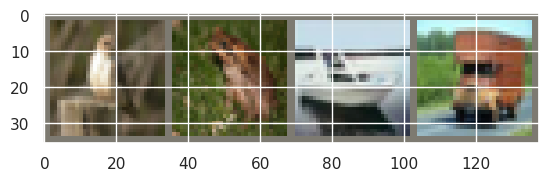

 bird  frog  ship truck


In [45]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
show_tensor(torchvision.utils.make_grid(images[:4]))
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

# 2. Define Lenet with/without dropout

In [42]:
# Lenet without dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Lenet with dropout
class Net_DO(nn.Module):
    def __init__(self):
        super(Net_DO, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout(x)))
        x = self.fc3(self.dropout(x))
        return x


# Lenet with MCDO
class Net_MCDO(nn.Module):
    def __init__(self):
        super(Net_MCDO, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(self.dropout(self.conv1(x)))
        x = self.pool(self.dropout(self.conv2(x)))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout(x)))
        x = F.softmax(self.fc3(self.dropout(x)), dim=1)
        return x


def update_target(target, original, update_rate):
    for target_param, param in zip(target.parameters(), original.parameters()):
        target_param.data.copy_(
            (1.0 - update_rate) * target_param.data + update_rate * param.data
        )

# 3. Define a Loss function and optimizer

In [10]:
CE = nn.CrossEntropyLoss()

In [11]:
def train(epoch, net, net_test, optimizer, log_freq=log_freq):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = CE(outputs, labels)
        loss.backward()
        optimizer.step()
        update_target(net_test, net, 0.001)

        # print statistics
        running_loss += loss.item()
        if (i + 1) % log_freq == 0:  # print every 2000 mini-batches
            print(
                "[Epoch : %d, Iter: %5d] loss: %.3f"
                % (epoch + 1, i + 1, running_loss / log_freq)
            )
    return running_loss / log_freq


def test(net, is_MCDO=False):
    print("Start test")
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = 0
            if is_MCDO:
                for i in range(10):
                    output += net(inputs) / 10.0
                output = torch.log(output)
            else:
                output = net(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print(
            "Accuracy of %5s : %.2f %%"
            % (classes[i], 100 * class_correct[i] / class_total[i])
        )

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

In [16]:
lenets = [Net, Net_DO, Net_MCDO]
epoch_num = 200
test_freq = 10
losses = list()
net_scores = list()
test_scores = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
is_train = True

# SAVE
def save(name, net, net_test):
    net_path = "../saved_models/" + name + ".pkl"
    net_test_path = "../saved_models/" + name + "_test.pkl"
    net = net.cpu()
    torch.save(net.state_dict(), net_path)
    net_test = net_test.cpu()
    torch.save(net_test.state_dict(), net_test_path)
    # Place it to GPU back
    net.to(device)
    net_test.to(device)
    return net, net_test


def load(name, net, net_test):
    net_path = "../saved_models/" + name + ".pkl"
    net_test_path = "../saved_models/" + name + "_test.pkl"
    # LOAD
    net.load_state_dict(torch.load(net_path))
    net_test.load_state_dict(torch.load(net_test_path))
    # Place it to GPU
    net.to(device)
    net_test.to(device)
    return net, net_test


def main():
    for lenet in lenets:
        print(lenet.__name__)
        net = lenet()
        net_test = lenet()
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            net = nn.DataParallel(net)
            net_test = nn.DataParallel(net_test)
        net.to(device)
        net_test.to(device)
        net_test.load_state_dict(net.state_dict())

        optimizer = optim.Adam(
            net.parameters(), lr=5e-4, weight_decay=0.0005, amsgrad=True
        )
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

        for i in tqdm_notebook(range(epoch_num)):
            scheduler.step()
            if lenet.__name__ == "Net_DO":
                net.train()
                net_test.train()
            loss_avg = train(epoch=i, net=net, net_test=net_test, optimizer=optimizer)
            losses.append(loss_avg)
            if (i + 1) % test_freq == 0:
                if lenet.__name__ == "Net_DO":
                    print("NET_DO TEST")
                    net.eval()
                    net_test.eval()
                if lenet.__name__ == "Net_MCDO":
                    print("NET_MCDO TEST")
                    print("Train net test")
                    net_score = test(net, is_MCDO=True)
                    net_scores.append(net_score)
                    print("Test net test")
                    test_score = test(net_test, is_MCDO=True)
                    test_scores.append(test_score)
                else:
                    print("Train net test")
                    net_score = test(net)
                    net_scores.append(net_score)
                    print("Test net test")
                    test_score = test(net_test)
                    test_scores.append(test_score)

        save(lenet.__name__, net, net_test)

In [17]:
if is_train:
    main()

Net
Let's use 4 GPUs!


/tmp/ipykernel_258646/2151037789.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epoch_num)):


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch : 1, Iter:    50] loss: 1.537
[Epoch : 2, Iter:    50] loss: 1.042
[Epoch : 3, Iter:    50] loss: 0.821
[Epoch : 4, Iter:    50] loss: 0.630
[Epoch : 5, Iter:    50] loss: 0.464
[Epoch : 6, Iter:    50] loss: 0.320
[Epoch : 7, Iter:    50] loss: 0.217
[Epoch : 8, Iter:    50] loss: 0.136
[Epoch : 9, Iter:    50] loss: 0.093
[Epoch : 10, Iter:    50] loss: 0.055
Train net test
Start test
Accuracy of plane : 79.10 %
Accuracy of   car : 82.80 %
Accuracy of  bird : 57.20 %
Accuracy of   cat : 54.50 %
Accuracy of  deer : 67.00 %
Accuracy of   dog : 60.20 %
Accuracy of  frog : 79.00 %
Accuracy of horse : 75.80 %
Accuracy of  ship : 79.20 %
Accuracy of truck : 78.80 %
71.35999999999999
Test net test
Start test
Accuracy of plane : 57.10 %
Accuracy of   car : 66.80 %
Accuracy of  bird : 35.20 %
Accuracy of   cat : 40.50 %
Accuracy of  deer : 37.20 %
Accuracy of   dog : 38.50 %
Accuracy of  frog : 59.90 %
Accuracy of horse : 71.70 %
Accuracy of  ship : 75.50 %
Accuracy of truck : 77.70 %


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch : 1, Iter:    50] loss: 1.624
[Epoch : 2, Iter:    50] loss: 1.167
[Epoch : 3, Iter:    50] loss: 0.955
[Epoch : 4, Iter:    50] loss: 0.820
[Epoch : 5, Iter:    50] loss: 0.698
[Epoch : 6, Iter:    50] loss: 0.604
[Epoch : 7, Iter:    50] loss: 0.507
[Epoch : 8, Iter:    50] loss: 0.415
[Epoch : 9, Iter:    50] loss: 0.356
[Epoch : 10, Iter:    50] loss: 0.258
NET_DO TEST
Train net test
Start test
Accuracy of plane : 81.30 %
Accuracy of   car : 83.10 %
Accuracy of  bird : 64.30 %
Accuracy of   cat : 59.30 %
Accuracy of  deer : 67.00 %
Accuracy of   dog : 63.90 %
Accuracy of  frog : 83.60 %
Accuracy of horse : 73.40 %
Accuracy of  ship : 80.90 %
Accuracy of truck : 77.90 %
73.47
Test net test
Start test
Accuracy of plane : 65.00 %
Accuracy of   car : 74.40 %
Accuracy of  bird : 28.00 %
Accuracy of   cat : 53.60 %
Accuracy of  deer : 31.00 %
Accuracy of   dog : 36.00 %
Accuracy of  frog : 35.10 %
Accuracy of horse : 60.80 %
Accuracy of  ship : 64.30 %
Accuracy of truck : 76.30 %


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch : 1, Iter:    50] loss: 2.119
[Epoch : 2, Iter:    50] loss: 1.996
[Epoch : 3, Iter:    50] loss: 1.932
[Epoch : 4, Iter:    50] loss: 1.884
[Epoch : 5, Iter:    50] loss: 1.845
[Epoch : 6, Iter:    50] loss: 1.814
[Epoch : 7, Iter:    50] loss: 1.793
[Epoch : 8, Iter:    50] loss: 1.772
[Epoch : 9, Iter:    50] loss: 1.755
[Epoch : 10, Iter:    50] loss: 1.727
NET_MCDO TEST
Train net test
Start test
Accuracy of plane : 77.40 %
Accuracy of   car : 86.40 %
Accuracy of  bird : 56.90 %
Accuracy of   cat : 50.70 %
Accuracy of  deer : 68.10 %
Accuracy of   dog : 52.00 %
Accuracy of  frog : 85.40 %
Accuracy of horse : 76.50 %
Accuracy of  ship : 78.10 %
Accuracy of truck : 78.40 %
70.99
Test net test
Start test
Accuracy of plane : 59.50 %
Accuracy of   car : 46.70 %
Accuracy of  bird : 19.40 %
Accuracy of   cat : 28.60 %
Accuracy of  deer : 43.80 %
Accuracy of   dog : 39.80 %
Accuracy of  frog : 59.10 %
Accuracy of horse : 48.50 %
Accuracy of  ship : 71.40 %
Accuracy of truck : 74.00 

In [18]:
len(net_scores)

60

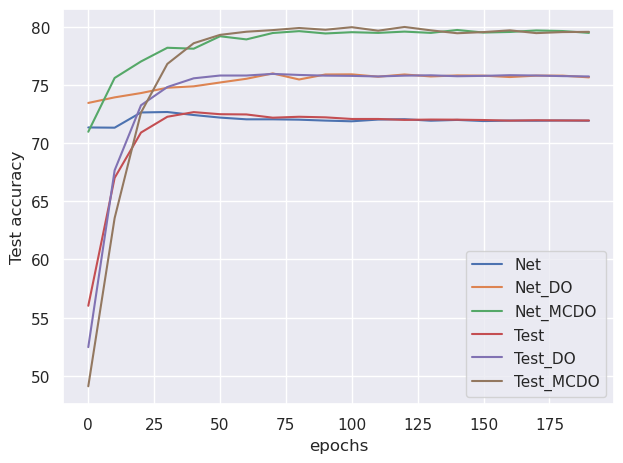

In [19]:
sns.set()
epochs = [10 * i for i in range(20)]
plt.plot(epochs, net_scores[:20], label="Net")
plt.plot(epochs, net_scores[20:40], label="Net_DO")
plt.plot(epochs, net_scores[40:], label="Net_MCDO")
plt.plot(epochs, test_scores[:20], label="Test")
plt.plot(epochs, test_scores[20:40], label="Test_DO")
plt.plot(epochs, test_scores[40:], label="Test_MCDO")
plt.xlabel("epochs")
plt.ylabel("Test accuracy")
plt.legend()
plt.tight_layout()
plt.show()